# 다이닝 코드 데이터

In [2]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

data = pd.read_csv('diningcode_data_crawling_20250905_1618.csv')

In [3]:
data = data.drop(columns=['Unnamed: 0'],axis=1)
data.shape

(3455, 15)

## Preprocessing data


In [4]:
# 다코 미식가 / user_name 분리
daco_list = dict()
name_list = list()
for i,val in enumerate(data['user_name']):
    if "다코미식가" in val:
        daco_list[i] = 1
    else:
        daco_list[i] = 0
    name_list.append(data['user_name'][i].replace('다코미식가',''))
data['daco_gourmand'] = daco_list

name_list = [name.replace('\r\n', '') for name in name_list]
data['user_name'] = name_list

In [5]:
data['user_rating'] = data['user_rating'].str.replace('점','').astype(float)

In [6]:
unique_vals = data['taste'].unique()
mapping_dict = {
    unique_vals[0]:3,
    unique_vals[1]:2,
    unique_vals[2]:1
}
data['taste_enc'] = data['taste'].map(mapping_dict)
del mapping_dict, unique_vals

unique_vals = data['service'].unique()
mapping_dict = {
    unique_vals[0]:3,
    unique_vals[1]:2,
    unique_vals[2]:1
}
data['service_enc'] = data['service'].map(mapping_dict)
del mapping_dict, unique_vals

unique_vals = data['price'].unique()
mapping_dict = {
    unique_vals[0]:3,
    unique_vals[1]:2,
    unique_vals[2]:1
}
data['price_enc'] = data['price'].map(mapping_dict)
del mapping_dict, unique_vals

In [7]:
le = LabelEncoder()
data['user_id'] = le.fit_transform(data['user_name'])
data['item_id'] = le.fit_transform(data['item_name'])

## EDA

<Axes: xlabel='item_id', ylabel='item_avg_rating'>

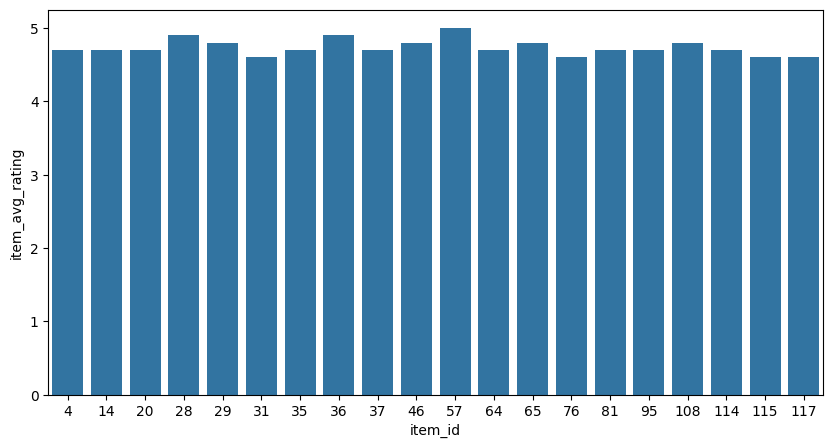

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

top_20_item = data[['item_id','item_avg_rating']].sort_values(by='item_avg_rating',ascending=False).drop_duplicates()[:20]
plt.figure(figsize=(10,5))
sns.barplot(data=top_20_item,x='item_id',y='item_avg_rating')

In [9]:
user_item_mat = pd.pivot_table(data=data,index='item_id',
                               columns='user_id',values='user_rating')
print('sparsity : ',np.count_nonzero(np.isnan(user_item_mat)) / user_item_mat.size)
print(f'user_item_mat shape : {user_item_mat.shape}')

sparsity :  0.9819017523700087
user_item_mat shape : (118, 1298)


In [10]:
import sys
sys.path.append('../..')  # Go up two levels to reach the directory containing 'Study'

from Study.RecSys.matrixfactorization import matfac
from Study.RecSys.SVD.SVD import SVD
R_large = user_item_mat.fillna(0)
R = np.array(R_large)

k=10
lr=0.01
reg_param = 0.01
epochs=30

mf_model = matfac.MatrixFactorization(R,k,lr,reg_param,epochs)

mf_model.fit()

Epoch : 0 , RMSE : 3.1274
Epoch : 5 , RMSE : 2.9207
Epoch : 10 , RMSE : 3.3988
Epoch : 15 , RMSE : 3.5935
Epoch : 20 , RMSE : 3.6617
Epoch : 25 , RMSE : 3.6869


In [11]:
R_pred = mf_model.predict()
R_pred.shape

(118, 1298)

In [19]:
def ndcg_at_k(y_true, y_score, k=-1): #Vector의 계산으로 이루어짐
    y_true = np.array(y_true)
    y_score = np.array(y_score)
    n = len(y_true)
    # k가 -1 또는 데이터 전체보다 크면 k=n으로 보정
    if k == -1 or k > n:
        k = n

    order = np.argsort(y_score)[::-1]
    y_true_sorted = y_true[order[:k]]  # k 길이만큼만 자름
    dcg = np.sum((2 ** y_true_sorted - 1) / np.log2(np.arange(2, k + 2)))
    best_dcg = np.sum((2 ** np.sort(y_true)[::-1][:k] - 1) / np.log2(np.arange(2, k + 2)))

    return dcg / best_dcg if best_dcg > 0 else 0.0

ndcg_k = []
for i,col in enumerate(R_pred):
    ndcg_k.append(ndcg_at_k(R[i],R_pred[i],k=-1))
print('ndcg@k mean:' , np.mean(ndcg_k))

ndcg@k mean: 0.3305156015183604
